In [1]:
%load_ext autoreload
%autoreload 2

from inversion.utils import *
from inversion.GAN import *

from tqdm.notebook import tqdm

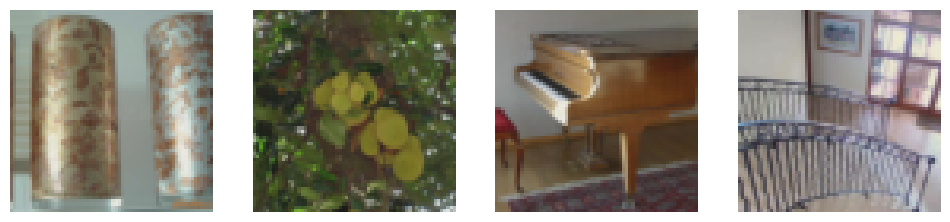

In [2]:
train_loader, test_loader = get_imagenet_loader(batch_size=256, resolution=64)
plot(denormalize(next(iter(train_loader))[0][:4]))

## Learn a feature -> noise mapping

Loading model from ./checkpoints/DCGen_64_128_2048/2024-10-28T22:30:02_epoch_23.pth


/home/hpc/iwi1/iwi1106h/Projects/BUBE/inversion/utils.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoints[-1]))


Loading model from ./checkpoints/mapper-fc-bn-relu-fc-bn/2024-10-29T01:30:40_epoch_04.pth


Epoch 1/100:   0%|          | 0/5005 [00:00<?, ?batch/s]

tensor([[6.8518e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 3.5999e-03,
         5.0294e-01],
        [1.5985e+00, 4.9593e-01, 3.0454e+00,  ..., 7.0089e-01, 9.2738e+00,
         2.2456e+00],
        [6.2339e-02, 3.4970e-01, 6.4569e-01,  ..., 6.9786e-01, 1.5584e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 2.5915e+00,  ..., 0.0000e+00, 7.9213e-01,
         8.8834e-01],
        [0.0000e+00, 0.0000e+00, 5.3563e-01,  ..., 8.3223e-01, 9.4913e-01,
         0.0000e+00],
        [4.5822e-01, 0.0000e+00, 9.9314e-02,  ..., 3.7370e-01, 5.2275e-01,
         6.3356e-02]], device='cuda:0')
Stats torch.Size([256, 2048]): 0.8754078149795532, 1.3730839490890503


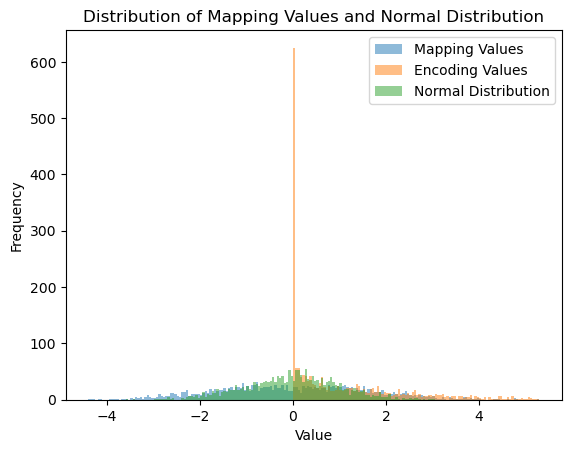

[Epoch    0/100]
 [Batch     0/ 5005
 [Mapper Loss: 1.104966402053833 = 0.9814953804016113 + 1.234710454940796]


KeyboardInterrupt: 

In [8]:
generator = DCGenerator(input_size=2048, base_features=128).to('cuda')
generator_id = "DCGen_64_128_2048"
get_latest_checkpoint(generator, model_id=generator_id)
encoder_initial = init_torch_resnet()
encoder_loss = init_torch_resnet()
# Freeze the weights of the encoders
for param in generator.parameters():
    param.requires_grad = False
for param in encoder_initial.parameters():
    param.requires_grad = False
for param in encoder_loss.parameters():
    param.requires_grad = False

mapper = nn.Sequential(
    nn.Linear(2048, 2048),
    nn.BatchNorm1d(2048),
    nn.LeakyReLU(0.2),
    nn.Linear(2048, 2048),
    nn.BatchNorm1d(2048),
).to('cuda')

get_latest_checkpoint(mapper, model_id="mapper-fc-bn-relu-fc-bn")

# Define the optimizer and loss function
optimizer_m = torch.optim.Adam(mapper.parameters(), lr=0.002, betas=(0.5, 0.999))
criterion = nn.MSELoss()


# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
        for i, (images, _) in enumerate(train_loader):
            # Move images to CUDA
            images = images.to('cuda')
            encodings = encoder_initial(images)
            print(encodings)

            # Generate a batch of images
            #z = torch.randn(images.size(0), 2048, device='cuda')
            mapping = mapper(encodings)
            gen_images = generator(mapping)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_m.zero_grad()
            mapper.zero_grad()


            # Loss measures generator's ability to fool the discriminator
            embedding_loss = criterion(encodings, encoder_loss(gen_images))
            image_loss = criterion(images, gen_images)

            m_loss = embedding_loss + 0.1*image_loss

            m_loss.backward()
            optimizer_m.step()

            if i % 10000 == 0:
                data = mapping[:1].detach().cpu().numpy().flatten()
                bin_width = 0.05
                bins = np.arange(min(data), max(data) + bin_width, bin_width)
                
                plt.hist(data, bins=bins, alpha=0.5, label='Mapping Values')
                data = encodings[:1].detach().cpu().numpy().flatten()
                plt.hist(data, bins=bins, alpha=0.5, label='Encoding Values')
                print(f"Stats {encodings.size()}: {torch.mean(encodings).item()}, {torch.std(encodings).item()}")

                # Plot a normal distribution for comparison
                normal_samples = np.random.normal(loc=0, scale=1, size=data.shape)
                plt.hist(normal_samples, bins=bins, alpha=0.5, label='Normal Distribution')
                
                plt.title("Distribution of Mapping Values and Normal Distribution")
                plt.xlabel("Value")
                plt.ylabel("Frequency")
                plt.legend()
                plt.show()
                print(f"[Epoch {epoch:4d}/{num_epochs:2d}]\n" +
                    f" [Batch {i:5d}/{len(train_loader):5d}\n" + 
                    f" [Mapper Loss: {m_loss.item()} = {embedding_loss.item()} + {image_loss.item()}]"
                    )
                plot(denormalize(torch.cat([
                    gen_images[:10],
                    images[:10],
                    gen_images[10:20],
                    images[10:20],
                    gen_images[20:30],
                    images[20:30],
                    gen_images[30:40],
                    images[30:40],
                    gen_images[40:50],
                    images[40:50]
                    ])), texts=(["Generated"]*10 + ["Original"]*10)*5)
                plt.show()
            pbar.update(1)

                
        checkpoint_suffix = f"epoch_{epoch:02d}"
        save_model(mapper, "mapper-fc-bn-relu-fc-bn", checkpoint_suffix=checkpoint_suffix)